In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive

[Errno 2] No such file or directory: 'gdrive'
/content/gdrive


In [ ]:
cd MyDrive

/content/gdrive/MyDrive


In [ ]:
cd Colab datasets

/content/gdrive/MyDrive/Colab datasets


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as mplot

from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import math

In [ ]:
XTrain=pd.read_csv("x_train_data.csv")
XTest=pd.read_csv("x_test_data.csv")
YTrain=pd.read_csv("y_train.csv")
YTest=pd.read_csv("y_test.csv")

In [ ]:
XTrain.head(5)

,Category,CounterSpeech,commentText,date,hasReplies,id,likes,numberOfReplies,timestamp,user,Community,replies
0,Default,False,wasnt even surprised said actors didnt believe...,3 years ago,0.0,Ugj9_a6p-pCTkHgCoAEC,0,0.0,2015-01-05 16:27:02.809,SvAg,jews,[]
1,5,True,going done ball group person evil get excuse m...,7 years ago,0.0,UgweYtkh98TTUX156M54AaABAg,0,0.0,2011-12-06 09:43:19.992,Neojhun,black,[]
2,Default,False,gay alteration ur stupid mind forced give sata...,5 years ago,0.0,Ugw6ESunxYnBZu05sfR4AaABAg,0,0.0,2012-12-05 04:48:03.679,tellit2yastr8,lgbt,[]
3,Default,False,forgiveness something separation changed news ...,5 months ago,0.0,Ugj_TcgR6vXTZHgCoAEC,0,0.0,2017-07-05 04:41:28.158,john dennis,lgbt,[]
4,"5,9",True,bitches racist hate backbite fucking,4 months ago,0.0,UgyHINlb_aSDTD7nK9Z4AaABAg,0,0.0,2018-08-13 05:48:20.758,gaby gonzalez,black,[]


In [ ]:
XTest.head(5)

,Category,CounterSpeech,commentText,date,hasReplies,id,likes,numberOfReplies,timestamp,user,Community,replies
0,Default,False,truth god,5 months ago,0.0,UgyOn3XdzLd7WGtpR014AaABAg,0,0.0,2018-07-04 16:13:05.830,David Malapile,jews,[]
1,"5,9",True,stunned disgusting hateful hell sick homosexua...,4 years ago,0.0,Ugz2jIERhfSlbTT3I5N4AaABAg,0,0.0,2013-12-05 04:47:49.740,Fangirl Smith,lgbt,[]
2,4,True,muslim video makes emotional,1 month ago,0.0,UgzqreWMOeDIUDRbOAR4AaABAg,0,0.0,2017-12-05 16:22:40.118,nadeem malik,jews,[]
3,Default,False,racist opinions reporter matter kids mom dont ...,5 months ago,0.0,Ugwu32empR4tRwqs67J4AaABAg,0,0.0,2018-07-13 05:49:34.356,sirlozervilleskidmarx,black,[]
4,8,True,mess up i,4 months ago,0.0,UgyNGc4NKGXCuYXAZKF4AaABAg,0,0.0,2018-08-13 05:48:21.986,Lilsourpach Kid,black,[]


In [ ]:
YTrain.head(5)

,CounterSpeech
0,False
1,True
2,False
3,False
4,True


In [ ]:
YTest.head(5)

,CounterSpeech
0,False
1,True
2,True
3,False
4,True


### **Word2Vec**

In [ ]:
import gensim
from gensim.models.word2vec import Word2Vec
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [ ]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

#  Reads text.txt file
f = open("text.txt", "w")
f.truncate(0)
for i in range(len(XTrain)):
  f.write(XTrain.iloc[i, 2])
f.close()

sample = open("text.txt", "r")
s = sample.read()


# Replaces escape character with space
f = s.replace("\n", " ")
  
data = []
  
# iterate through each sentence in the file
for i in sent_tokenize(f):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data.append(temp)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
model_w2v = gensim.models.Word2Vec(
            data,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=5, # Ignores all words with total frequency lower than 5.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 30, # no.of cores
            seed = 34) 

model_w2v.train(data, total_examples= len(XTrain['commentText']), epochs=20)

(200000, 16127380)

In [ ]:
w1 = "muslim"
model_w2v.wv.most_similar (positive=w1)

[('jew', 0.9807682037353516),
 ('islam', 0.9709647297859192),
 ('anti', 0.9705650806427002),
 ('muslims', 0.9660741686820984),
 ('religion', 0.9601702094078064),
 ('cant', 0.9594258069992065),
 ('jews', 0.9591585397720337),
 ('semi', 0.9583747386932373),
 ('today', 0.9554988145828247),
 ('israel', 0.9540188312530518)]

In [ ]:
w1 = "black"
model_w2v.wv.most_similar (positive=w1)

[('white', 0.9833188652992249),
 ('racist', 0.9682799577713013),
 ('media', 0.957857608795166),
 ('person', 0.9574815034866333),
 ('police', 0.9550235867500305),
 ('damn', 0.9524862766265869),
 ('brutality', 0.9521309733390808),
 ('people', 0.9508342742919922),
 ('beat', 0.9499897956848145),
 ('crime', 0.9499017000198364)]

In [ ]:
embeddings_index = {}
for w in model_w2v.wv.vocab.keys():
    embeddings_index[w] = model_w2v.wv[w]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(XTrain['commentText'])
sequences = tokenizer.texts_to_sequences(XTrain['commentText'])

In [ ]:
for x in XTrain.iloc[:5, 2]:
    print(x)

wasnt even surprised said actors didnt believe minute
going done ball group person evil get excuse murdering average race sadistic american sentences helping idea pass evil acts problem issue bashed life person citizen is fun people law group excuse cant get young pin race fun goliath reduce involved people issue illogical blame using
gay alteration ur stupid mind forced give satan rim job hell sure isnt hate right know trying help losers like wrong i
forgiveness something separation changed news kept night wanted christ jesus self years something brings life born father death hated asking dont gave created christian church christ life news sinless answer lord god talking read years night took judgment gift gave felt change going jesus kirk deserve ask believe good like something learn love debut side found perfect forth fallen life could life went started cross jesus eternal hard savor christ jesus everything else righteousness night god could good many began ago jesus christ coward r

In [ ]:
#sequences[:5]

In [ ]:
length = []
for x in XTrain['commentText']:
    length.append(len(x.split()))
max(length)

3095

In [ ]:
length = []
for x in XTest['commentText']:
    length.append(len(x.split()))
max(length)

3026

In [ ]:
XTrain_seq = pad_sequences(sequences, maxlen=3100)
XTrain_seq[:5]

array([[   0,    0,    0, ...,   69,   25, 1457],
       [   0,    0,    0, ..., 4287,  444,  419],
       [   0,    0,    0, ...,    3,   41,    4],
       [   0,    0,    0, ..., 1085, 3384,  206],
       [   0,    0,    0, ...,    9, 2074,   73]], dtype=int32)

In [ ]:
sequences_Test = tokenizer.texts_to_sequences(XTest['commentText'])
XTest_seq = pad_sequences(sequences_Test, maxlen=3100)

In [ ]:
XTest_seq[:5]

array([[   0,    0,    0, ...,    0,   40,    2],
       [   0,    0,    0, ...,   49,  184,   80],
       [   0,    0,    0, ...,   68,  139, 2276],
       [   0,    0,    0, ...,  261, 8986,  170],
       [   0,    0,    0, ..., 1636,  233,    4]], dtype=int32)

In [ ]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
np.array_equal(embedding_matrix[25] ,embeddings_index.get('believe'))

True

### **CNN Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

In [ ]:
model = Sequential()
model.add(Embedding(100000, 200, input_length=3100))
model.add(Conv1D(64, 3, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3100, 200)         20000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 3098, 64)          38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1549, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 99136)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               24784250  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 44,822,965
Trainable params: 44,822,965
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(XTrain_seq, YTrain, validation_data=(XTest_seq, YTest), epochs=15, batch_size=128, verbose=2)

Epoch 1/15
380/380 - 1360s - loss: 0.4917 - accuracy: 0.7534 - val_loss: 0.3271 - val_accuracy: 0.8619
Epoch 2/15
380/380 - 1324s - loss: 0.1683 - accuracy: 0.9346 - val_loss: 0.2246 - val_accuracy: 0.9117
Epoch 3/15
380/380 - 1348s - loss: 0.0668 - accuracy: 0.9749 - val_loss: 0.2257 - val_accuracy: 0.9253
Epoch 4/15
380/380 - 1321s - loss: 0.0306 - accuracy: 0.9891 - val_loss: 0.2624 - val_accuracy: 0.9226
Epoch 5/15
380/380 - 1327s - loss: 0.0183 - accuracy: 0.9938 - val_loss: 0.2913 - val_accuracy: 0.9292
Epoch 6/15
380/380 - 1332s - loss: 0.0187 - accuracy: 0.9937 - val_loss: 0.3411 - val_accuracy: 0.9201
Epoch 7/15
380/380 - 1332s - loss: 0.0266 - accuracy: 0.9907 - val_loss: 0.3852 - val_accuracy: 0.9167
Epoch 8/15
380/380 - 1341s - loss: 0.0237 - accuracy: 0.9919 - val_loss: 0.4334 - val_accuracy: 0.9139
Epoch 9/15
380/380 - 1334s - loss: 0.0157 - accuracy: 0.9947 - val_loss: 0.4065 - val_accuracy: 0.9205
Epoch 10/15
380/380 - 1365s - loss: 0.0135 - accuracy: 0.9962 - val_loss:

In [ ]:
print('Final training loss \t', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss 	 0.016661956906318665
Final training accuracy  0.9941285252571106


In [ ]:
testLoss, testAccuracy = model.evaluate( XTest_seq, YTest)

651/651 [==============================] - 137s 210ms/step - loss: 0.4284 - accuracy: 0.9193


In [ ]:
print('Testing loss  \t', testLoss)
print('Testing accuracy ', testAccuracy)

Testing loss  	 0.4283749759197235
Testing accuracy  0.9192943572998047


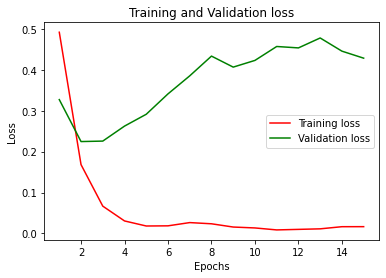

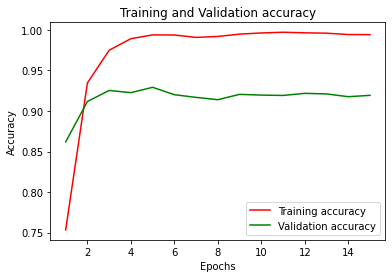

In [ ]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
mplot.plot(epochs, loss, color='red', label='Training loss')
mplot.plot(epochs, val_loss, color='green', label='Validation loss')
mplot.title('Training and Validation loss')
mplot.xlabel('Epochs')
mplot.ylabel('Loss')
mplot.legend()
mplot.show()

# plotting training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
mplot.plot(epochs, acc, color='red', label='Training accuracy')
mplot.plot(epochs, val_acc, color='green', label='Validation accuracy')
mplot.title('Training and Validation accuracy')
mplot.xlabel('Epochs')
mplot.ylabel('Accuracy')
mplot.legend()
mplot.legend()
mplot.show()

In [ ]:
YPred = model.predict(XTest_seq)
YPred = (YPred > 0.5)

In [ ]:
print(classification_report(YTest, YPred))

              precision    recall  f1-score   support

       False       0.92      0.92      0.92     10584
        True       0.92      0.92      0.92     10220

    accuracy                           0.92     20804
   macro avg       0.92      0.92      0.92     20804
weighted avg       0.92      0.92      0.92     20804

